# 12th February

---------------
The SAC data has been loaded, converted and written out as a usable ASCII encoding through a CentOS VM - explored in the SAC to ASCII notebook. This is the second and last of the notebooks that need to be run within a Linux VM - We are using some CLI-level bash functions to stream through all of our data more efficiently, something that is more difficult to achieve in Windows' Command Prompt shell.


## ASCII Data Correction

------------------

Although the file is in a usuable encoding, it is still not useful to us - the file includes headers, and the waveform data is just amplitude, without timeseries data. Let's take a closer look at the data... 

In [1]:
import pandas as pd
import numpy as np
import os
from __future__ import division
from ipywidgets import FloatProgress
from IPython.display import display
import time
import matplotlib
import matplotlib.pyplot as plt
from itertools import islice
from tqdm import tqdm
%matplotlib notebook

In [2]:
lines =[]
with open("../../Data/DATA/WHOLE_DAY_DATA/AllData/ASCII/2011.240.00.00.00.0000.YW.NAB1..HHE.D.txt") as f:
    lines.extend(f.readline() for i in xrange(100))
    
lines

['     0.01000000      -450115.0       370702.0      -12345.00      -12345.00\n',
 '       0.000000       86399.98      -12345.00       83524.06       2.000000\n',
 '      -12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n',
 '      -12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n',
 '      -12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n',
 '      -12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n',
 '      -12345.00       13.38730       41.65540       1329.000       0.000000\n',
 '      -12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n',
 '      -12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n',
 '      -12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n',
 '      -12345.00      -12345.00      -12345.00      -12345.00      -12345.00\n',
 '      -12345.00      -7765.873       90.00000       90.00000      -12345.00\n',
 '      -12345.0

The first thirty rows are a header, and following rows are five columns of data, reading across not down.

The full header documentation is available in the sac documentation on the IRIS website, (http://ds.iris.edu/files/sac-manual/manual/file_format.html) but the most important part of the header for us is the very fist value: the time interval between the data points - 0.01 seconds.
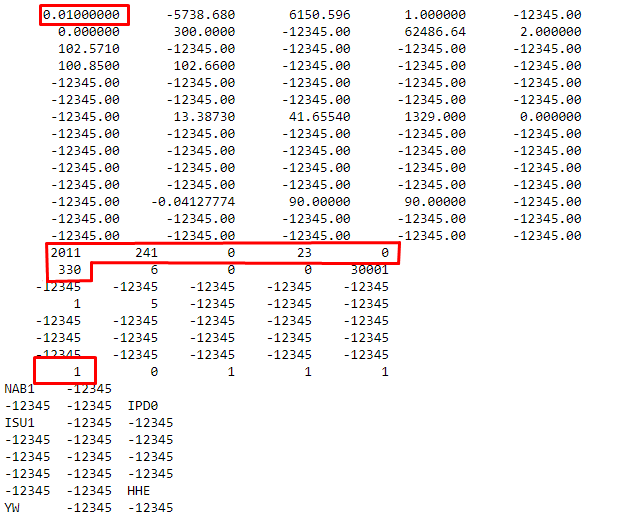

Because the data is lacking a timeseries column, we have to reconstruct this information. We can pull the starting datetime from the header (second red block highlighted) as _YYYY|DDD|HH|MM|SS|UUU_, However, the actual datetime isn't relevant to this project, so all we need is time interval, as our datapoints occur at constant time intervals. It is extrememly unusual to see seismic recordings at uneven time intervals, and the _**LEVEN**_ header block (the third block highlighted) confirms that the timing is constant.

it should be noted that the time delta between datapoints does have an impact on the data: Niquist's Theorem states that the sampling frequency should be twice the highest frequency you hope to capture - conversely, the highest signal you can accurately record without aliasing is half the sampling rate.

$$Given\ that\ the\ time\ delta\ is\ 0.01\ seconds\ and\ Periodicity =  Frequency^{-1}\\
Periodicity = 0.01\ sec\ \therefore\ Frequency = 100Hz\\
Nyquist\ Limit = \frac{1}{2}Frequency\\
Highest\ possible\ frequency\ is\ 50Hz$$

Given that earthquake waves tend to be comfortably below 50Hz, the time interval is appropriate for us.

------------------
### Ingestion

Now that we know the interval, we can ommit the headers when we fully ingest the data.

In [2]:
test_df = pd.read_csv("./../../../DATA/ASCII/2011.241/20110829.002440.YW.NAB1.HHE.txt", skiprows=29)

In [3]:
test_df

,YW -12345 -12345
0,276.5661 217.9904 121.5382 ...
1,-7.074997 6.970520 -20.01669 ...
2,-197.4135 -182.7622 -164.8450 ...
3,-62.17136 44.15514 130.0897 ...
4,141.4552 122.6967 71.41003 ...
5,-41.54811 34.03430 146.2155 ...
6,338.2267 343.9159 333.8680 ...
7,291.1913 260.2289 199.2132 ...
8,20.75454 -4.698323 -33.12268 ...
9,-162.0288 -146.7795 -103.6307 ...


although we've dropped the headers, the 5 columns of data are still condensed into one - they're whitespace seperated, rather than comma or tab seperated. Even worse, the number of spaces is inconsistent. We'll need to remove the spaces and replace them with carriage returns so it appears as a single column csv format.

The easiest way is to elevate it to BASH, and run it through _awk_ - in this case, I'm using _gawk_. Awk will let us do in text modifications  in a fast commandline environment. We will also use _tr_ (translate), which let's us easily remove all occurences of a given character easily. The statement we are going to pass is:

```bash
awk 'NR  > 30 { print }' [FILENAME]| tr -d '\\n' | awk 'gsub(" +", "\\n") {print}' > TARGETDIRECTORY/FILENAME

awk 'NR > 30 { print }' [FILENAME]#Take the file given, skip the first 30 rows (our header) and  print out the rest of the file

tr -d '\\n' #Take the input passed from awk, and delete (-d) any occurence of a newline, print the file

awk 'gsub(" +", "\\n" {print}' > TARGETDIRECTORY/FILENAME #Take input from tr, and globally subtitute (gsub) any occurence of one or more spaces (" +"). Replace them with a newline character. Pipe into a new textfile within a different directory
```

We can create each line by using format on the string, iterating down the list of filenames, after changing to the right directory.

In [3]:
% cd "/media/sf_Dropbox_(Personal)/Github/Nabro_ANN/Nabro_ANN/Data/DATA/WHOLE_DAY_DATA/AllData/ASCII"

/media/sf_Dropbox_(Personal)/Github/Nabro_ANN/Nabro_ANN/Data/DATA/WHOLE_DAY_DATA/AllData/ASCII


In [4]:
file_list = os.listdir(".")


total_no_files = len(file_list)
for item in tqdm(file_list):
    awk_command="""awk 'NR  > 30 {}' {}| tr -d '\\n' | awk 'gsub(" +", "\\n") {}' > './headless_only/'{}""".format('{ print }', item, '{ print }', item)
    os.system(awk_command)
    

100%|██████████| 46/46 [08:22<00:00, 10.92s/it]


With the files all converted, let's take a look at one of the files to see what has changed.

In [6]:
lines =[]
with open("./headless_only/2011.240.00.00.00.0000.YW.NAB1..HHE.D.txt") as f:
    lines.extend(f.readline() for i in xrange(100))
    
lines

['\n',
 '-8290.000\n',
 '-8253.000\n',
 '-8337.000\n',
 '-7883.000\n',
 '-7459.000\n',
 '-7260.000\n',
 '-7167.000\n',
 '-7264.000\n',
 '-7558.000\n',
 '-7935.000\n',
 '-8169.000\n',
 '-8260.000\n',
 '-8456.000\n',
 '-8812.000\n',
 '-8843.000\n',
 '-8532.000\n',
 '-8173.000\n',
 '-7941.000\n',
 '-7670.000\n',
 '-7381.000\n',
 '-7244.000\n',
 '-7263.000\n',
 '-7122.000\n',
 '-7170.000\n',
 '-7419.000\n',
 '-7571.000\n',
 '-7416.000\n',
 '-7288.000\n',
 '-7296.000\n',
 '-7493.000\n',
 '-7601.000\n',
 '-8005.000\n',
 '-8397.000\n',
 '-8599.000\n',
 '-8913.000\n',
 '-8921.000\n',
 '-8823.000\n',
 '-8755.000\n',
 '-8826.000\n',
 '-8874.000\n',
 '-8914.000\n',
 '-9067.000\n',
 '-9150.000\n',
 '-9193.000\n',
 '-9186.000\n',
 '-9142.000\n',
 '-8990.000\n',
 '-8809.000\n',
 '-8571.000\n',
 '-8531.000\n',
 '-8879.000\n',
 '-9202.000\n',
 '-9413.000\n',
 '-9504.000\n',
 '-9272.000\n',
 '-9074.000\n',
 '-8705.000\n',
 '-8484.000\n',
 '-8479.000\n',
 '-8369.000\n',
 '-8059.000\n',
 '-7882.000\n',
 

With the datapoints finally in the right format, we can generate the timeseries data for each one - the final step needed before we start to process the data itself.

In [8]:
test_dataframe = pd.read_csv("./headless_only/2011.240.00.00.00.0000.YW.NAB1..HHE.D.txt", header=None, names = ['Amplitude'])
generated_array = np.arange(0, 0.01*len(test_dataframe), 0.01)
test_dataframe['TimeSeries'] = generated_array
test_dataframe.set_index('TimeSeries', inplace=True)

Let's take a look at the data now...

<IPython.core.display.Javascript object>


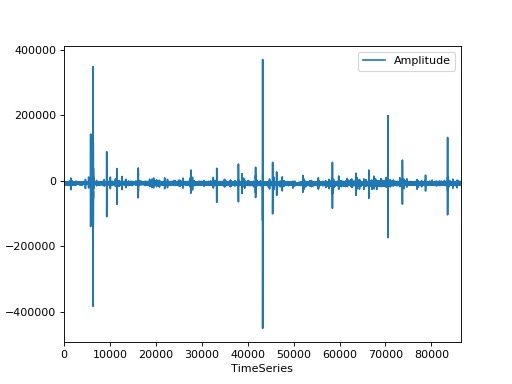

In [9]:
test_dataframe.plot()

That looks like the sort of output we'd expect for a seismic event.

-----

Now to automating it...

Let's get a list of files, create an function to replicate what we've done for the first file, and push the data to a new and final directory.

In [29]:
def timeseries_generator(input_filepath, output_filepath):
    amplitude_only_dataframe = pd.read_csv(input_filepath, header=None, names = ['Amplitude'])
    timeseries_array = np.arange(0, 0.01*len(amplitude_only_dataframe), 0.01)
    amplitude_only_dataframe['TimeSeries'] = timeseries_array
    amplitude_only_dataframe.set_index('TimeSeries', inplace=True)
    amplitude_only_dataframe.to_csv(output_filepath)

In [38]:
%cd "/media/sf_Dropbox_(Personal)/Github/Nabro_ANN/Nabro_ANN/Data/DATA/headless_only"
!dir

/media/sf_Dropbox_(Personal)/Github/Nabro_ANN/Nabro_ANN/Data/DATA/headless_only
2011.240.00.00.00.0000.YW.NAB1..HHE.D.txt
2011.240.00.00.00.0000.YW.NAB1..HHN.D.txt
2011.240.00.00.00.0000.YW.NAB1..HHZ.D.txt
2011.240.00.00.00.0000.YW.NAB4..HHE.D.txt
2011.240.00.00.00.0000.YW.NAB4..HHZ.D.txt
2011.240.00.00.00.0000.YW.NAB6..HHN.D.txt
2011.241.00.00.00.0000.YW.NAB1..HHE.D.txt
2011.241.00.00.00.0000.YW.NAB2..HHZ.D.txt
2011.241.00.00.00.0000.YW.NAB5..HHZ.D.txt
2011.242.00.00.00.0000.YW.NAB3..HHN.D.txt
2011.242.00.00.00.0000.YW.NAB3..HHZ.D.txt
2011.242.00.00.00.0000.YW.NAB4..HHN.D.txt
2011.242.00.00.00.0000.YW.NAB4..HHZ.D.txt
2011.242.00.00.00.0000.YW.NAB5..HHN.D.txt
2011.242.00.00.00.0000.YW.NAB8..HHZ.D.txt
2011.243.00.00.00.0000.YW.NAB1..HHZ.D.txt
2011.243.00.00.00.0000.YW.NAB3..HHN.D.txt
2011.243.00.00.00.0000.YW.NAB3..HHZ.D.txt
2011.243.00.00.00.0000.YW.NAB4..HHZ.D.txt
2011.244.00.00.00.0000.YW.NAB2..HHE.D.txt
2011.244.00.00.00.0000.YW.NAB2..HHN.D.txt
2011.244.00.00.00.0000.YW.NAB2..HHZ.D.

In [41]:
file_list = os.listdir('.')
file_list = file_list[:-1]
new_file_paths = map(lambda x: "./TimeseriesAndAmplitude/{}".format(x),file_list)

In [42]:
i = 0
for item in tqdm(file_list):
    timeseries_generator(file_list[i], new_file_paths[i])
    i += 1

100%|██████████| 45/45 [37:52<00:00, 50.50s/it]
